In [14]:
import sys; sys.path.insert(0, '..')

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

import trajectory_reconstruction_tradeoff as T
import random
import scanpy as sc
import altair as alt
from altair_saver import save

import warnings
warnings.filterwarnings('ignore')
random.seed(20)

In [1]:
dirname = '../output/datasets/' 
outdir = '../output/results/'

datasets = ['linear',
            'bifur_at_1',
            'bifur_at_2',
            'bifur_at_3',
            'bifur_at_1_to_3',
            'bifur_at_2_to_3',
            'bifur_at_1_to_4',
            ]

# colors = ['blue', 'darkred', 'maroon', 'brown', 'firebrick', 'indianred', 'lightcoral', ]
colors = {'linear': 'navy', 
          'bifur_at_1': 'blue', 
          'bifur_at_2': 'deepskyblue',#'cyan', 
          'bifur_at_3': 'aquamarine', 
          'bifur_at_1_to_3': 'lightsalmon', 
          'bifur_at_2_to_3': 'tomato', 
          'bifur_at_1_to_4': 'red', }

dims = {'linear': 1,
        'bifur_at_1': 2,
        'bifur_at_2': 2,
        'bifur_at_3': 2,
        'bifur_at_1_to_3': 3,
        'bifur_at_2_to_3': 3,
        'bifur_at_1_to_4': 4,
        }

In [4]:
# # params
# Pvar = np.round(0.03 * 2 ** np.arange(0, 5, 0.6), 2)
# Pconst = np.ones_like(Pvar)
# repeats = 10

In [3]:
# # read all data
# ndims = 4
# fig, ax = plt.subplots(ndims, 3, figsize=(20,20))

# trajs = {}
# ndatas = 1
# dim_count = np.zeros(ndims).astype(int)
# for dataset in datasets:
#     datafiles = glob.glob(os.path.join(dirname, f'{dataset}_rep*.h5ad'))
#     for datafile in datafiles[:ndatas]:
#         print(datafile)
#         dataname = os.path.basename(datafile).split('.')[0]
#         adata = sc.read_h5ad(datafile)
#         X = adata.X
#         meta = adata.obs
#         traj = T.tr.Trajectory(X, meta=meta)
#         d = int(dims[dataset] - 1)
#         T.pl.plot_pca2d(traj.pX, meta=meta, title=dataset, color='branch', ax=ax[d, dim_count[d]])
#         dim_count[d]+=1
#         trajs[dataname] = traj

In [4]:
ndatasets = 10
postfix = '_single.csv' if ndatasets == 1 else '.csv'

L_cells = pd.read_csv(os.path.join(outdir, 'prosstt_L_cells.csv'))

In [5]:
# compute transformations
L_cells['inv pc'] = 1 / L_cells['pc']
L_cells['log pc'] = np.log(L_cells['pc'])
L_cells['log l1'] = np.log(L_cells['l1'])

# deltas
ncells = 1000
L_cells['delta'] = L_cells['Delta0'] / L_cells['pc'] / ncells
L_cells['log delta'] = np.log(L_cells['delta'])

# compute npaths
islinear = L_cells['trajectory type'] == 'linear' 
L_cells['dim'] = L_cells.apply(lambda x: dims[x['trajectory type']], axis=1)
L_cells['nbranches'] = L_cells['dim'] + 1
L_cells.loc[islinear,'nbranches'] = 1
L_cells['npaths'] = L_cells.apply(lambda x: comb(x['nbranches'], 2), axis=1)

### Visualize

In [8]:
Pcs = L_cells['pc'].unique()

PCA dimensions reflect the dimension of the tree


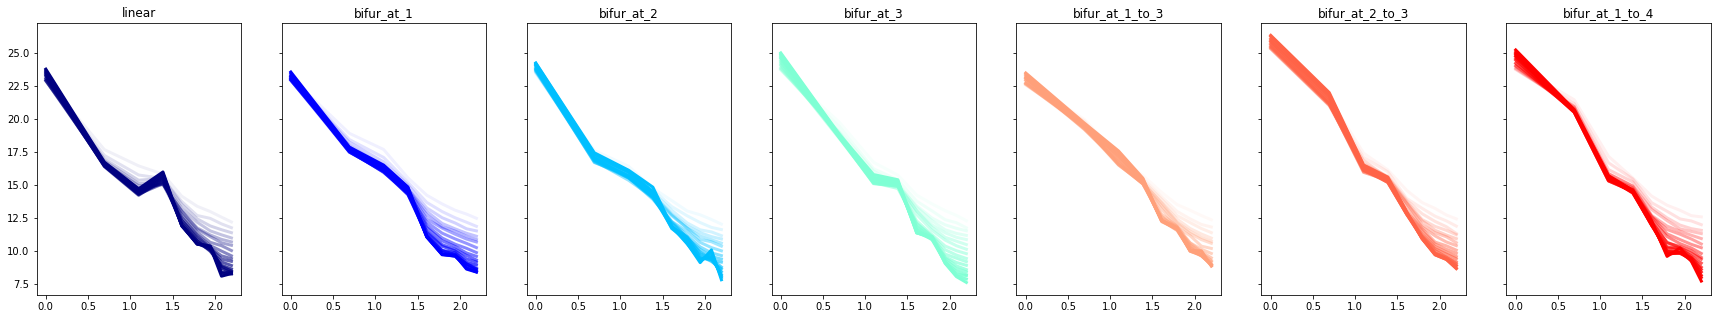

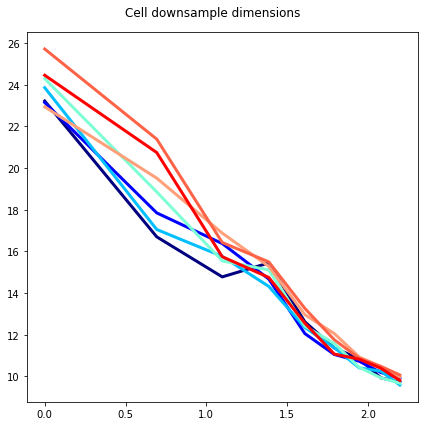

In [22]:

print('PCA dimensions reflect the dimension of the tree')
fig, ax = plt.subplots(1, len(datasets), figsize=(30,5), sharex=True, sharey=True)
fig2, ax2 = plt.subplots(1, figsize=(6,6))
pc_dims = np.arange(10)
nPcs = len(Pcs)

for idata, data in enumerate(datasets):
    color = colors[data]
    sL = L_cells[L_cells['trajectory type'] == data]
    ax[idata].set_title(data)
    pc_means = sL[['Delta%d' % pc_dim for pc_dim in pc_dims]].mean()
    ax2.plot(np.log(pc_dims), pc_means, alpha=(ipc+1)/nPcs, color=color, linewidth=3, label=data)    
    for ipc, pc in enumerate(Pcs):
        ssL = sL[sL['pc'] == pc]
        pc_means = ssL[['Delta%d' % pc_dim for pc_dim in pc_dims]].mean()
        ax[idata].plot(np.log(pc_dims), pc_means, alpha=(ipc+1)/nPcs, color=color, linewidth=3, label=data)
        

plt.suptitle('Cell downsample dimensions')  
# ax.legend()
plt.tight_layout()

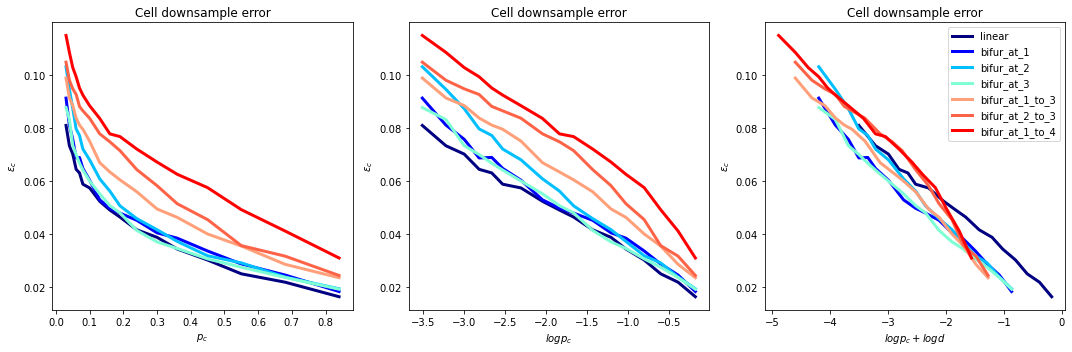

In [30]:
from scipy.special import comb

## Visualizing current
nplots = 3
plot_std = 0
fig, ax = plt.subplots(1, nplots, figsize=(5*nplots,5))

ax[0].set_title(r'Cell downsample error')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    T.pl.plot_tradeoff(sL, xcol='pc', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[0], plot_std=plot_std, xlabel=r'$p_c$', ylabel=r'$\epsilon_c$')

ax[1].set_title(r'Cell downsample error')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    T.pl.plot_tradeoff(sL, xcol='log pc', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[1], plot_std=plot_std, xlabel=r'$log p_c$', ylabel=r'$\epsilon_c$')

ax[2].set_title(r'Cell downsample error')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    sL['tmp'] = sL['log pc'] - np.log(dim)
    T.pl.plot_tradeoff(sL, xcol='tmp', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[2], plot_std=plot_std, xlabel=r'$log p_c - log d$', ylabel=r'$\epsilon_c$')

ax[nplots-1].legend()
plt.tight_layout()


In [76]:
sL.groupby('log pc').mean()['log l1'].diff().mean()

-0.08604276314736656

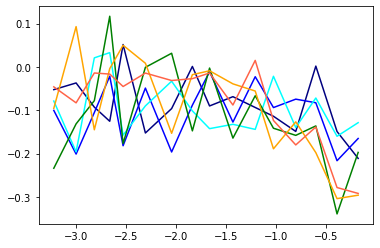

In [85]:
for data in datasets:
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    grp_sL = sL.groupby('log pc').mean()
    der = grp_sL['log l1'].diff().iloc[1:]
    npaths = grp_sL['npaths'].mean()
    plt.plot(der.index, der.values, color=colors[data])

Avg slope of linear trajectory: -1.000


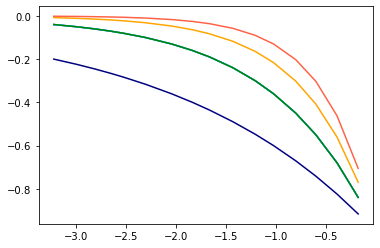

In [100]:
# prediction
# suppose for linear, slope is const

sL = L_cells[L_cells['trajectory type'] == 'linear'].copy()
grp_sL = sL.groupby('log pc').mean()
pcs = grp_sL['pc'].values[1:]
der = grp_sL['log l1'].diff().iloc[1:]
xvals = der.index
linear_slope = -1#der.mean()
print('Avg slope of linear trajectory: %.03f' % linear_slope)

# for bifurcating, 
for data in datasets:

    sL = L_cells[L_cells['trajectory type'] == data].copy()
    dim = sL['dim'].mean()
    pred_der = linear_slope * (pcs)**(dim/2)
    plt.plot(xvals, pred_der, color=colors[data])

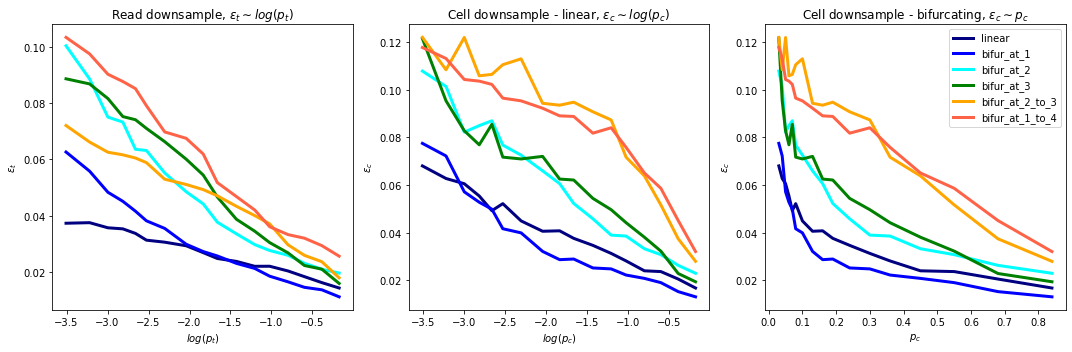

In [26]:
## Visualizing without log on error
nplots = 3
fig, ax = plt.subplots(1, nplots, figsize=(5*nplots,5))

ax[0].set_title(r'Read downsample, $\epsilon_t \sim log(p_t)$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_reads[L_reads['trajectory type'] == data].copy()
    T.pl.plot_tradeoff(sL, xcol='log pt', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[0], plot_std=0, xlabel=r'$log(p_t)$', ylabel=r'$\epsilon_t$')

ax[1].set_title(r'Cell downsample - linear, $\epsilon_c \sim log(p_c)$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    T.pl.plot_tradeoff(sL, xcol='log pc', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[1], plot_std=0, xlabel=r'$log(p_c)$', ylabel=r'$\epsilon_c$')

ax[2].set_title(r'Cell downsample - bifurcating, $\epsilon_c \sim p_c$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    T.pl.plot_tradeoff(sL, xcol='pc', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[2], plot_std=0, xlabel=r'$p_c$', ylabel=r'$\epsilon_c$')
    

ax[nplots-1].legend()
plt.tight_layout()


In [14]:
for dataset in datasets:
    sL = L_reads[L_reads['trajectory type'] == dataset].copy()
    sL.index = sL['log pt']
    median_slope = np.round(sL['l1'].diff().iloc[1:].median(), 5)
    print(f'{dataset} slope: {median_slope}')

linear slope: -0.04445
bifur_at_1 slope: -0.09237
bifur_at_2 slope: -0.09844
bifur_at_3 slope: -0.09382
bifur_at_1_to_3 slope: -0.06899
bifur_at_2_to_3 slope: -0.05219
bifur_at_1_to_4 slope: -0.07146


In [15]:
for dataset in datasets:
    sL = L_cells[L_cells['trajectory type'] == dataset].copy()
    sL.index = sL['log pc']
    median_slope = np.round(sL['l1'].diff().iloc[1:].median(), 5)
    print(f'{dataset} slope: {median_slope}')

linear slope: -0.11778
bifur_at_1 slope: -0.11376
bifur_at_2 slope: -0.13815
bifur_at_3 slope: -0.06062
bifur_at_1_to_3 slope: -0.03727
bifur_at_2_to_3 slope: -0.18924
bifur_at_1_to_4 slope: -0.06342


## Tradeoff

In [6]:
Bs = [0.0001, 0.001, 0.01]

# Pc = Pvar
# L_tradeoff_dict = {}
# for traj_name, traj in trajs.items():
#     L_tradeoff_per_traj = []
#     for B in Bs:
#         L_tradeoff_per_traj.append(traj.compute_tradeoff(B=B, Pc=Pc, repeats=repeats))
#     L_tradeoff_dict[traj_name] = pd.concat(L_tradeoff_per_traj)

In [53]:
L_tradeoff = pd.read_csv(os.path.join(dirname, 'prosstt_L_tradeoff.csv'))

In [54]:
L_tradeoff['log pc'] = np.log(L_tradeoff['pc'])

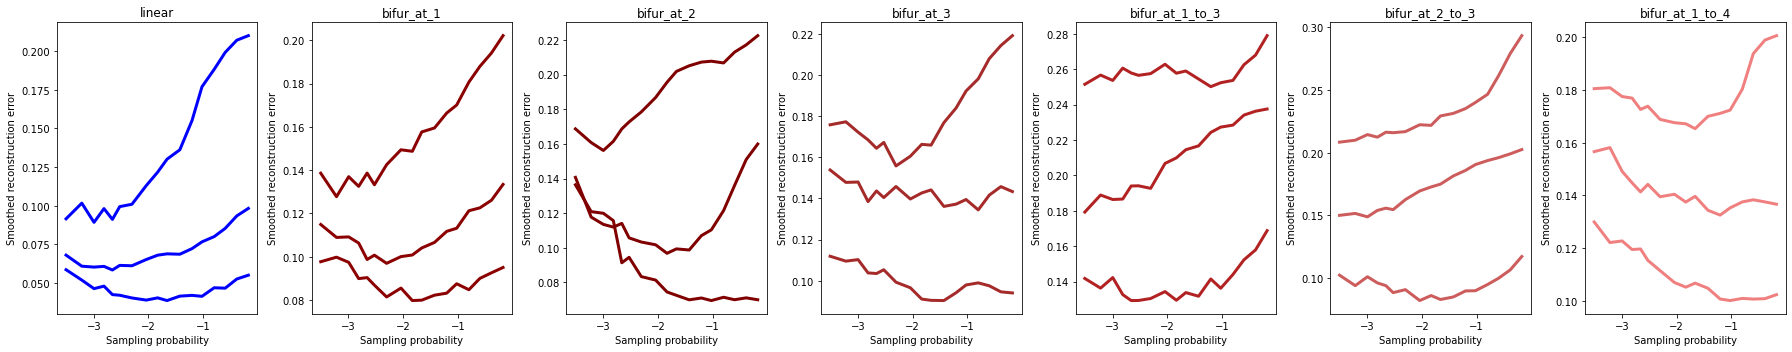

In [60]:
fig, ax = plt.subplots(1, len(datasets), figsize=(25,5))

ax[0].set_title('Tradeoff')
for idata, data in enumerate(datasets):
    sL = L_tradeoff[L_tradeoff['trajectory type'] == data]
    # sL = L_tradeoff[L_tradeoff['level_0'] == data + '_rep1']
    color = colors[idata]
    for B in Bs:
        ssL = sL[sL['B'] == B]
        pc_opt = T.opt.find_min_nc(ssL)
        T.pl.plot_tradeoff(ssL, xcol='log pc', color_mean=color, color_std=color, label=data, ax=ax[idata], plot_std=0)#, pc_opt=pc_opt)
    ax[idata].set_title(data)

plt.tight_layout()